In [1]:
from google.colab import drive
 
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from sklearn import metrics
# from geopy.geocoders import Nominatim

import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point

import matplotlib.pyplot as plt
%matplotlib inline

# Reading Data

In [3]:
train_data = pd.read_csv("/gdrive/MyDrive/dataset/ZS Associates/train_file.csv")
test_data = pd.read_csv("/gdrive/MyDrive/dataset/ZS Associates/test_file.csv")

In [4]:
train_data.head()

Application/Permit Number  ...                Category
0                    6640280  ...  SINGLE FAMILY / DUPLEX
1                    6452959  ...              COMMERCIAL
2                    6435127  ...              COMMERCIAL
3                    6620870  ...              COMMERCIAL
4                    6363778  ...              COMMERCIAL

[5 rows x 19 columns]

In [5]:
print("Train shape:",train_data.shape)
print("Test shape:",test_data.shape)

Train shape: (33539, 19)
Test shape: (22360, 18)


### Generating and Analysing basic stats

In [6]:
ProfileReport(train_data, title="Pandas Profiling Report")

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
train_data['data']='train'
test_data['data']='test'
data = pd.concat([train_data,test_data],axis=0, sort=True)
data.head(5)

Action Type               Address  ...       Work Type   data
0     ADD/ALT       1924 10TH AVE E  ...  No plan review  train
1     ADD/ALT  9434 DELRIDGE WAY SW  ...     Plan Review  train
2     ADD/ALT       535 TERRY AVE N  ...  No plan review  train
3  DEMOLITION         830 4TH AVE S  ...     Plan Review  train
4     ADD/ALT       805 NE 106TH ST  ...     Plan Review  train

[5 rows x 20 columns]

## Data Exploration

In [8]:
train_data[train_data['Permit Type'] == 'Demolition']['Category'].value_counts()

SINGLE FAMILY / DUPLEX    1744
MULTIFAMILY                596
COMMERCIAL                 413
INSTITUTIONAL               44
INDUSTRIAL                  29
Name: Category, dtype: int64

In [9]:
train_data[train_data['Application Date'].isna()]['Status'].value_counts()

Initial Information Collected    5185
CANCELLED                         117
Information Collected              60
Permit Closed                       2
AP Closed                           1
Name: Status, dtype: int64

In [10]:
train_data[train_data['Issue Date'].isna()]['Category'].value_counts()

SINGLE FAMILY / DUPLEX    5257
COMMERCIAL                3263
MULTIFAMILY               1569
INSTITUTIONAL              340
INDUSTRIAL                 195
Name: Category, dtype: int64

In [11]:
train_data[train_data['Issue Date'].isna()]['Status'].value_counts()

Initial Information Collected    5185
Application Accepted             1522
CANCELLED                        1346
Reviews Completed                 540
AP Closed                         384
Information Collected              60
Permit Closed                       8
Inspections Added                   3
AP Finaled                          1
Permit Issued                       1
Name: Status, dtype: int64

In [12]:
train_data[train_data['Issue Date'].isna()]['Status'].value_counts()

Initial Information Collected    5185
Application Accepted             1522
CANCELLED                        1346
Reviews Completed                 540
AP Closed                         384
Information Collected              60
Permit Closed                       8
Inspections Added                   3
AP Finaled                          1
Permit Issued                       1
Name: Status, dtype: int64

In [13]:
temp_data = pd.crosstab(index=train_data['Status'], 
                             columns=train_data['Category'],
                             margins=True)
cols = list(temp_data.columns)
cols.remove('All')
cols.append("rowtotal")
temp_data.columns = cols
cols = list(temp_data.index)
cols.remove('All')
cols.append("coltotal")
temp_data.index = cols

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print((temp_data/temp_data.loc["coltotal"]).round(2))

                               COMMERCIAL  INDUSTRIAL  INSTITUTIONAL  \
AP Closed                            0.00        0.02           0.01   
AP Finaled                           0.00        0.00           0.00   
Application Accepted                 0.04        0.04           0.05   
CANCELLED                            0.06        0.07           0.04   
Cert of Occupancy Authorized         0.00        0.00           0.00   
Information Collected                0.00        0.01           0.00   
Initial Information Collected        0.20        0.33           0.22   
Inspections Added                    0.00        0.00           0.00   
Permit Closed                        0.52        0.34           0.48   
Permit Finaled                       0.00        0.00           0.00   
Permit Issued                        0.16        0.19           0.20   
Reviews Completed                    0.01        0.01           0.01   
coltotal                             1.00        1.00           

In [14]:
train_data['Application Date'] = pd.to_datetime(train_data['Application Date'])
train_data['Final Date'] = pd.to_datetime(train_data['Final Date'])
train_data['Issue Date'] = pd.to_datetime(train_data['Issue Date'])
train_data['Expiration Date'] = pd.to_datetime(train_data['Expiration Date'])

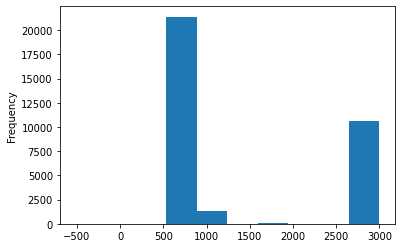

In [15]:
train_data['diff'] = (train_data['Expiration Date']-train_data['Issue Date']).astype('timedelta64[D]')
train_data['diff'].fillna(3000,  inplace=True) # Just to keep the missing values away froom the distribution
train_data['diff'].astype('int')
train_data['diff'].plot.hist()

## Data Processing

Calculate the time taken for an application and categorize it in less than or equal to 1 year, 1<x<=2, >3 years

In [16]:
data['Application Date'] = pd.to_datetime(data['Application Date'])
data['Final Date'] = pd.to_datetime(data['Final Date'])

time_taken = (data['Final Date']-data['Application Date']).astype('timedelta64[D]')
data['Time taken(years)'] = pd.Series()
data['Time taken(years)'] = np.where(time_taken.isna(), 'Undefined', data['Time taken(years)']) # these are the ones that either don't have final or appl date
data['Time taken(years)'] = np.where(time_taken <= 365, '<=1', data['Time taken(years)'])
data['Time taken(years)'] = np.where((time_taken > 365) & (time_taken <= 2*365) , 
                               '<=2', data['Time taken(years)'])
data['Time taken(years)'] = np.where(time_taken > 2*365, '>3', data['Time taken(years)'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


Combining categories with frequencies less than 5%

In [17]:
status_threshold = train_data['Status'].value_counts(normalize=True)<0.05
less_frequent_status = status_threshold.index[status_threshold == True].tolist()
data['Status'].replace(less_frequent_status, 'Other', inplace=True)

In [18]:
action_type_threshold = train_data['Action Type'].value_counts(normalize=True)<0.05
less_frequent_action = action_type_threshold.index[action_type_threshold == True].tolist()
data['Action Type'].replace(less_frequent_action, 'Other', inplace=True)

In [19]:
# Storing identifier for test resul submission
test_id = pd.DataFrame(data = data[data['data'] == 'test']['Application/Permit Number'])

# Selecting features
data = data[['Action Type', 'Category', 'Latitude', 'Longitude', 'Status', 'Work Type', 'Time taken(years)', 'data']]

Imputing missing values

In [20]:
data['Action Type'].fillna('Other', inplace=True)
data['Status'].fillna('Other', inplace=True)

# Imputing with Seattle lat, long
data['Latitude'].fillna('47.60738819516483', inplace=True)
data['Longitude'].fillna('-122.32765425093399', inplace=True)

Splitting data back to train and test

In [21]:
train_data = data[data['data']=='train']
del train_data['data']

test_data = data[data['data']=='test']
del test_data['data']
del test_data['Category']

Analysing and Clustering geospatial data

In [22]:
train_data[['Latitude', 'Longitude']] = train_data[['Latitude', 'Longitude']].astype(float)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [23]:
def plot_geolocation_by_cluster(df, 
                                cluster=None, 
                                title=None, 
                                centers=None,
                                filename=None):
    '''
    This was referenced from https://towardsdatascience.com/finding-and-visualizing-clusters-of-geospatial-data-698943c18fed

    Function to plot latitude and longitude coordinates
    #####################
    Args:
        df: pandas dataframe 
            Contains id, latitude, longitude, and color (optional).
        cluster: (optional) column (string) in df 
            Separate coordinates into different clusters
        title: (optional) string
        centers: (optional) array of coordinates for centers of each cluster
        filename: (optional) string  
    #####################
    Returns:
        Plot with lat/long coordinates 
    '''
    
    # Transform df into geodataframe
    geo_df = gpd.GeoDataFrame(df.drop(['Latitude', 'Longitude'], axis=1),
                           crs={'init': 'epsg:4326'},
                           geometry=[Point(xy) for xy in zip(df.Longitude, df.Latitude)])
      
    # Set figure size
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    
    # Import Seattle Neighborhood Shape Files
    seattle_full = gpd.read_file('/content/SeattleGeoData/Seattle_Streets.shp')
    seattle_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', 
                      color='lightgrey', 
                      # label=seattle_full['nta_name'],
                      zorder=1)
    
    # Plot coordinates from geo_df on top of Seattle map
    if cluster is not None:
        
        geo_df.plot(ax=ax, column=cluster, alpha=0.5, 
                    cmap='viridis', linewidth=0.8, zorder=2)
        
        if centers is not None:
            centers_gseries = GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
            centers_gseries.plot(ax=ax, alpha=1, marker='X', color='red', markersize=100, zorder=3)
        
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()
        
        if filename is not None:
            fig.savefig(f'{filename}', bbox_inches='tight', dpi=300)
    else:
        geo_df.plot(ax=ax, alpha=0.5, cmap='viridis', linewidth=0.8, legend=True, zorder=2)
        
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()
        
    fig.clf()

Visualizing multiple k sizes in clustering

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


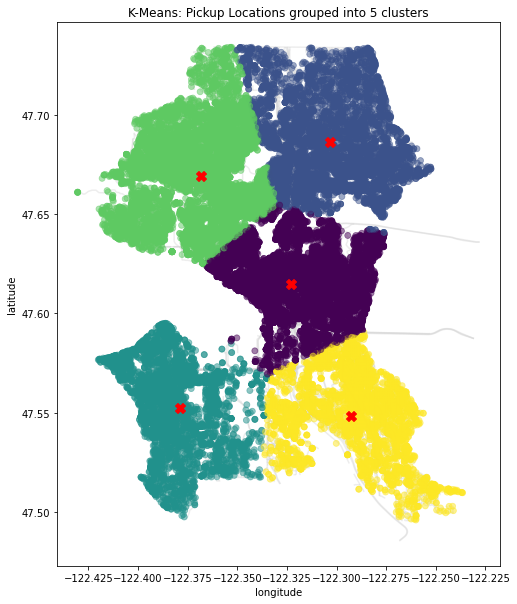

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


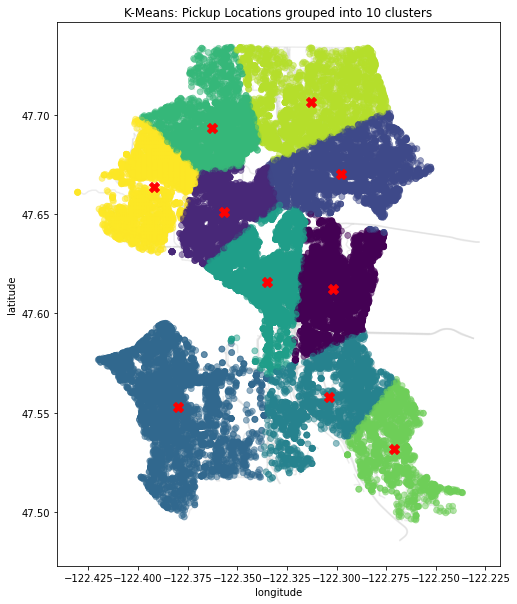

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


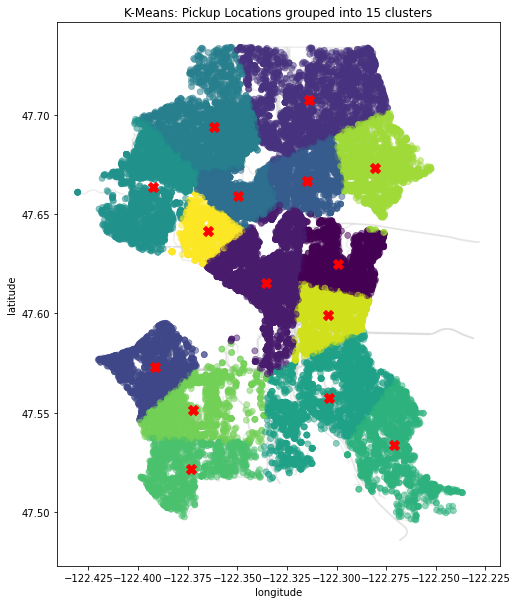

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


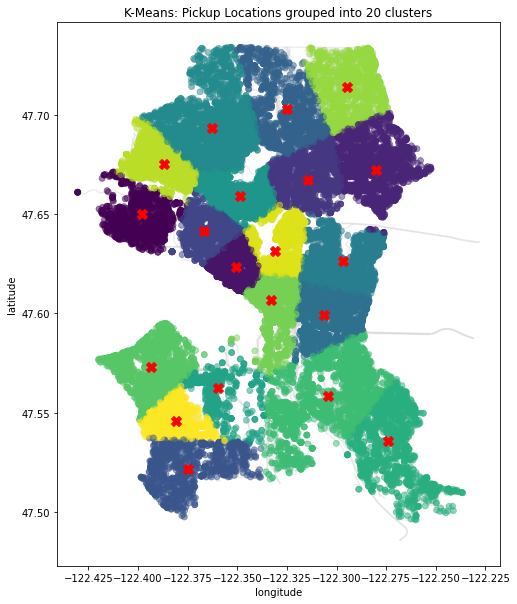

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


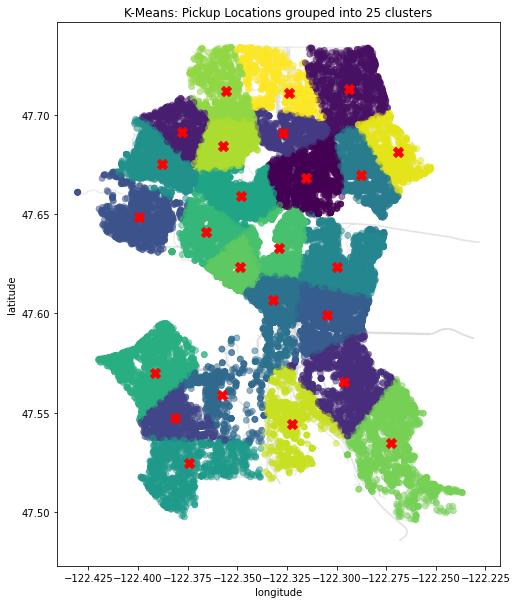

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


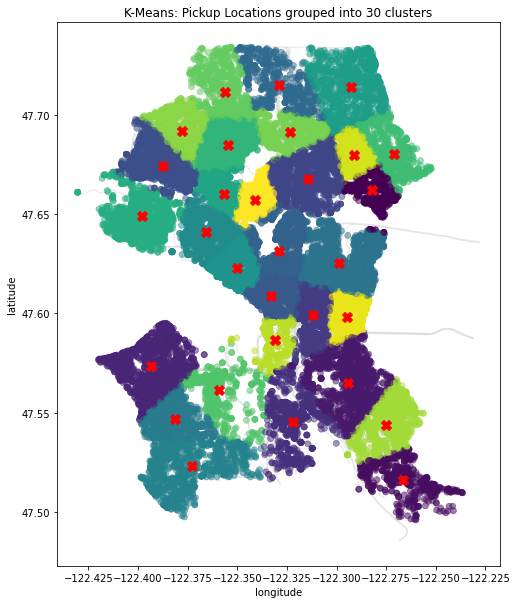

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


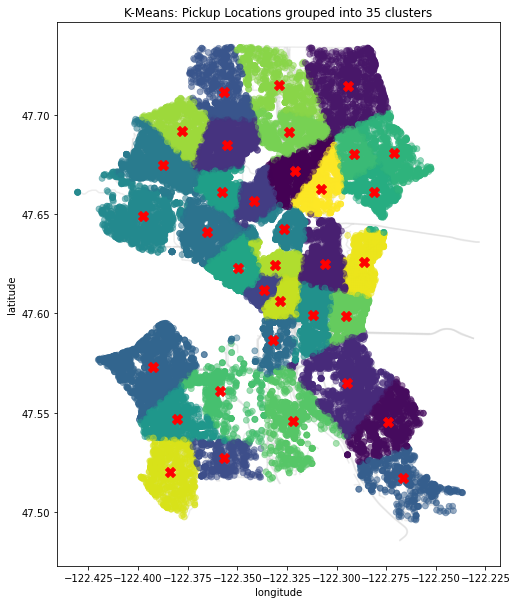

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


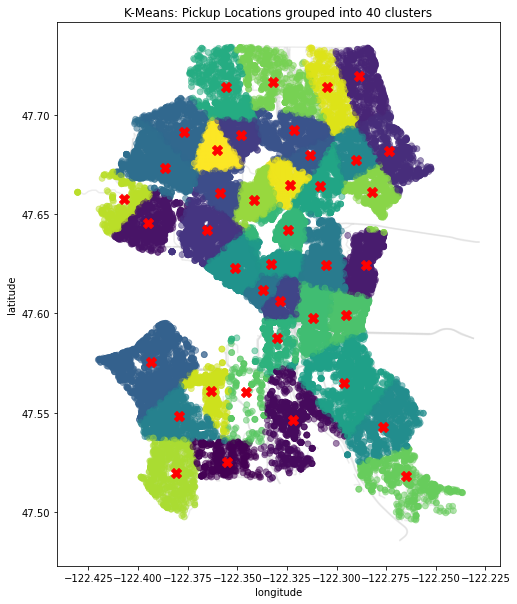

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


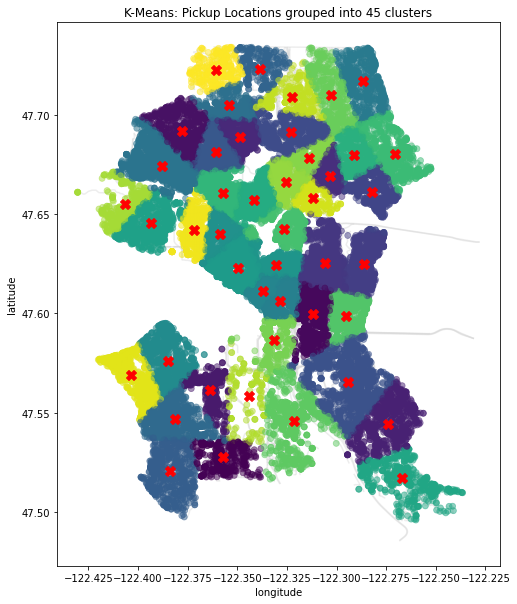

In [29]:
from sklearn.cluster import KMeans, MiniBatchKMeans

ssd = []

data_lat_long = train_data[['Latitude', 'Longitude']]
for i in range(5, 50, 5):
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(data_lat_long)
    centers = km.cluster_centers_
    ssd.append(km.inertia_)
    data_lat_long['cluster'] = km.labels_
    plot_geolocation_by_cluster(data_lat_long, cluster='cluster', 
                                title= f'K-Means: Pickup Locations grouped into {i} clusters',
                                centers=centers, filename=f'./plots/kmeans_{i}_clusters.png')

Clustering

In [ ]:
from sklearn.cluster import MiniBatchKMeans

km = MiniBatchKMeans(n_clusters=10)
km.fit_predict(train_data[['Latitude', 'Longitude']])
train_data['cluster'] = km.labels_

test_data['cluster'] = km.predict(test_data[['Latitude', 'Longitude']])

Analysing distribution based on Categories for clusters

In [31]:
temp_data = pd.crosstab(index=train_data['cluster'], 
                             columns=train_data['Category'],
                             margins=True)
cols = list(temp_data.columns)
cols.remove('All')
cols.append("rowtotal")
temp_data.columns = cols
cols = list(temp_data.index)
cols.remove('All')
cols.append("coltotal")
temp_data.index = cols

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print((temp_data/temp_data.loc["coltotal"]).round(2))

          COMMERCIAL  INDUSTRIAL  INSTITUTIONAL  MULTIFAMILY  \
0               0.03        0.03           0.06         0.10   
1               0.05        0.02           0.05         0.08   
2               0.39        0.11           0.28         0.27   
3               0.05        0.01           0.07         0.06   
4               0.06        0.17           0.05         0.09   
5               0.04        0.03           0.06         0.12   
6               0.22        0.07           0.08         0.14   
7               0.06        0.01           0.25         0.07   
8               0.06        0.52           0.04         0.02   
9               0.04        0.02           0.06         0.06   
coltotal        1.00        1.00           1.00         1.00   

          SINGLE FAMILY / DUPLEX  rowtotal  
0                           0.09      0.08  
1                           0.11      0.09  
2                           0.11      0.21  
3                           0.13      0.09  
4     

In [32]:
train_data.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
test_data.drop(['Latitude', 'Longitude'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
print("Data shape:",data.shape)
print("Train shape:",train_data.shape)
print("Test shape:",test_data.shape)

Data shape: (55899, 8)
Train shape: (33539, 6)
Test shape: (22360, 5)


## Encoding Categorical variables

In [34]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

d = defaultdict(LabelEncoder)
cat_cols = ['Action Type', 'Status', 'Work Type', 'Time taken(years)']
train_data.loc[:, cat_cols] = train_data[cat_cols].apply(lambda x: d[x.name].fit_transform(x))
target_encoder = LabelEncoder()
target_encoder.fit(train_data['Category'])
train_data['Category'] = target_encoder.transform(train_data['Category'])

test_data.loc[:, cat_cols] = test_data[cat_cols].apply(lambda x: d[x.name].transform(x))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Splitting data in train and validation sets

In [35]:
from sklearn.model_selection import train_test_split

train_data_x = train_data.loc[:, train_data.columns != 'Category']
train_data_y = train_data["Category"]
X_train, X_valid, y_train, y_valid = train_test_split(train_data_x, train_data_y, test_size=0.25, random_state=0)

# Training models on the data

RandomForest Default parameters classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier 

rf_clf = RandomForestClassifier()   
rf_clf.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Feature significances

In [37]:
feature_imp = pd.Series(rf_clf.feature_importances_,index=train_data_x.columns).sort_values(ascending=False)
feature_imp

cluster              0.527736
Action Type          0.215798
Work Type            0.097374
Time taken(years)    0.086921
Status               0.072172
dtype: float64

Evaluating metrics

In [38]:
# training score
pred_train = rf_clf.predict(X_train)
print("Training scores:")
print("F1 score:",metrics.f1_score(y_train, 
                                   pred_train, 
                                   average = 'weighted'))
print("Accuracy:",metrics.accuracy_score(y_train, pred_train))

Training scores:
F1 score: 0.6316233882032828
Accuracy: 0.6689989663671781


In [39]:
# validation score
pred = rf_clf.predict(X_valid)
print("Training scores:")
print("F1 score:",metrics.f1_score(y_valid, 
                                   pred,
                                   average = 'weighted'))
print("Accuracy:",metrics.accuracy_score(y_valid, pred))

Training scores:
F1 score: 0.6299682070833159
Accuracy: 0.6678592725104353


Decision Tree Classifier with default params

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt_clf = DecisionTreeClassifier(random_state=0)
cross_val_score(dt_clf, X_train, y_train, cv=5)

array([0.6591135 , 0.65811966, 0.65811966, 0.65692705, 0.6610338 ])

In [42]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [43]:
# training score
pred_train = dt_clf.predict(X_train)
print("Training scores:")
print("F1 score:",metrics.f1_score(y_train, 
                                   pred_train, 
                                   average = 'weighted'))
print("Accuracy:",metrics.accuracy_score(y_train, pred_train))



Training scores:
F1 score: 0.6318029557340675
Accuracy: 0.6689989663671781


In [44]:
# validation score
pred = dt_clf.predict(X_valid)
print("Training scores:")
print("F1 score:",metrics.f1_score(y_valid, 
                                   pred,
                                   average = 'weighted'))
print("Accuracy:",metrics.accuracy_score(y_valid, pred))

Training scores:
F1 score: 0.6294959075739376
Accuracy: 0.6676207513416815


Trying autoML to find the best model

In [ ]:
from tpot import TPOTClassifier
GENERATIONS = 10
POP_SIZE = 100
CV = 5

tpot = TPOTClassifier(
    generations=GENERATIONS,
    population_size=POP_SIZE,
    random_state=123,
    n_jobs=-1,
    # use_dask=True,
    periodic_checkpoint_folder="/gdrive/MyDrive/dataset/ZS Associates",
    cv=CV,
    verbosity=2,
)

tpot.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6877634530720665

Generation 2 - Current best internal CV score: 0.6881211953087675

Generation 3 - Current best internal CV score: 0.6881211953087675

Generation 4 - Current best internal CV score: 0.6881211953087675

Generation 5 - Current best internal CV score: 0.6881211953087675

Generation 6 - Current best internal CV score: 0.6881211953087675

Generation 7 - Current best internal CV score: 0.6881211953087675

Generation 8 - Current best internal CV score: 0.6881211953087675


Different models that were tried can be seen in this json

In [ ]:
import json

with open('tpot_evaluated_models.txt', 'w') as outfile:
    json.dump(tpot.evaluated_individuals_, outfile)

Exporting the best model that was found by tpot(AutoML)

In [ ]:
tpot.export('/gdrive/MyDrive/dataset/ZS \Associates/tpot_carnival_pipeline.py')

## Storing models

In [45]:
import pickle

pickle.dump(rf_clf, open('random_forest.pickle', 'wb'))
pickle.dump(dt_clf, open('decision_tree.pickle', 'wb'))

Training the best model tpot found

In [50]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot.builtins import ZeroCount
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
# tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
# features = tpot_data.drop('target', axis=1)
# training_features, testing_features, training_target, testing_target = \
#             train_test_split(features, tpot_data['target'], random_state=123)

# Average CV score on the training set was: 0.6937665045307562
exported_pipeline = make_pipeline(
    ZeroCount(),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=9, 
                               max_features=1.0, min_samples_leaf=7,
                               min_samples_split=2, n_estimators=100,
                               subsample=0.9000000000000001)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 123)

exported_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Pipeline(memory=None,
         steps=[('zerocount', ZeroCount()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.01, loss='deviance',
                                            max_depth=9, max_features=1.0,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=7,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            presort='d

In [51]:
# training score
pred_train = exported_pipeline.predict(X_train)
print("Training scores:")
print("F1 score:",metrics.f1_score(y_train, 
                                   pred_train, 
                                   average = 'weighted'))
print("Accuracy:",metrics.accuracy_score(y_train, pred_train))

Training scores:
F1 score: 0.6040316529078082
Accuracy: 0.6618032917229864


In [52]:
# validation score
pred = exported_pipeline.predict(X_valid)
print("Training scores:")
print("F1 score:",metrics.f1_score(y_valid, 
                                   pred,
                                   average = 'weighted'))
print("Accuracy:",metrics.accuracy_score(y_valid, pred))

Training scores:
F1 score: 0.6028522834701457
Accuracy: 0.662015503875969


In [53]:
pickle.dump(dt_clf, open('gbc.pickle', 'wb'))

Making test predictions

In [55]:
pred_test = exported_pipeline.predict(test_data)

test_id["Category"] = pred_test
test_id['Category'] = target_encoder.inverse_transform(test_id['Category'])
test_id.to_csv('./gbc_submission.csv', index=False)